In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T

spark = SparkSession.builder.getOrCreate()

elements = spark.read.csv(
"data/DataAnalysisWithPythonAndPySpark-Data-trunk/elements/Periodic_Table_Of_Elements.csv",
header=True,
inferSchema=True,
)

#elements.select("*").show()

#Write this select query in pyspark 
# SELECT period,count(*) FROM elements WHERE phase = 'liq' GROUP BY period;

elements.where(F.col("phase") == 'liq').groupby(F.col("period")).count().show()



23/11/01 13:21:11 WARN Utils: Your hostname, LAPTOP-JR3B3TTQ resolves to a loopback address: 127.0.1.1; using 172.28.169.28 instead (on interface eth0)
23/11/01 13:21:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/01 13:21:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/01 13:21:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+------+-----+
|period|count|
+------+-----+
|     6|    1|
|     4|    1|
+------+-----+



# SQL vs Spark SQL
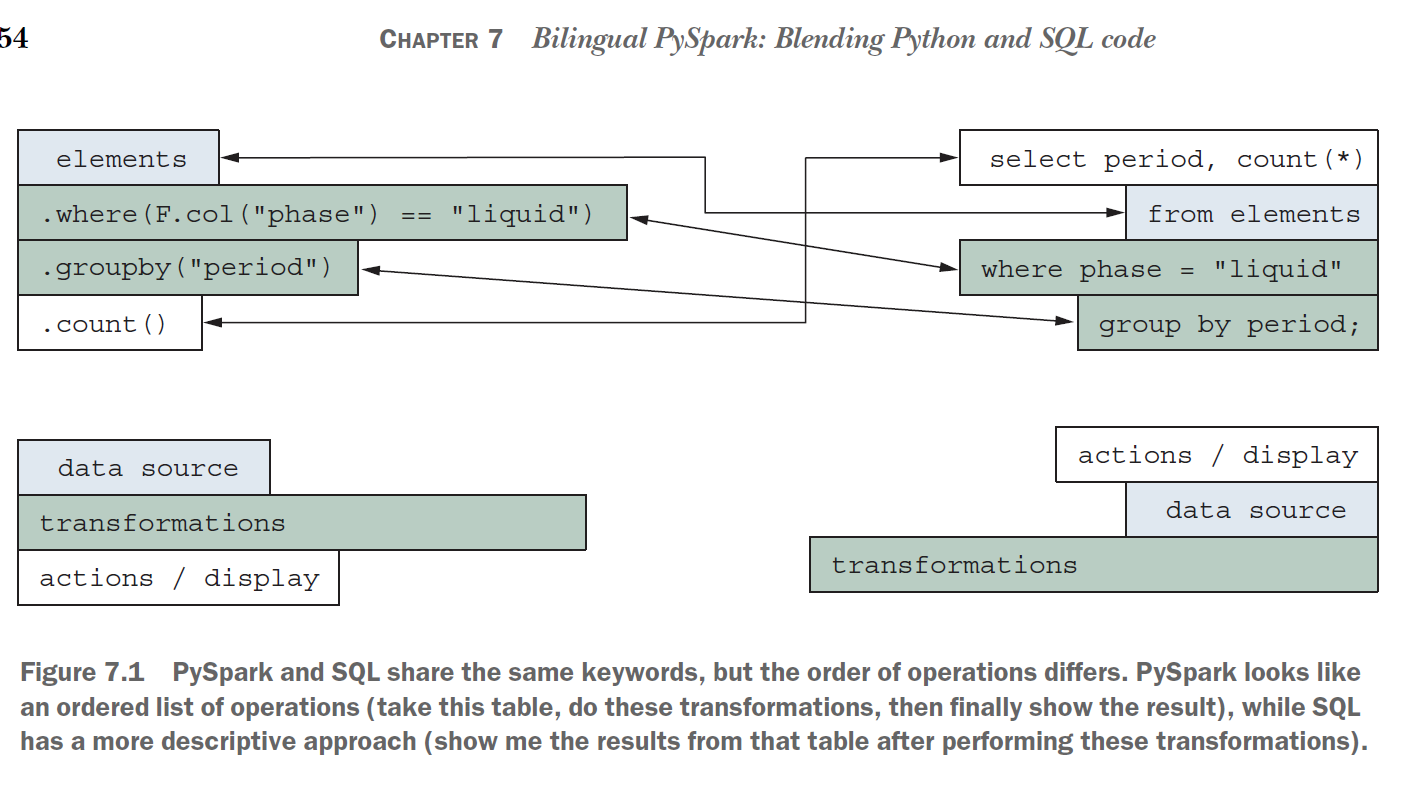

In [2]:
#Trying to query
try:
    spark.sql(
    "select period, count(*) from elements "
    "where phase='liq' group by period"
    ).show(5)
except AnalysisException as e:
    print(e)

[TABLE_OR_VIEW_NOT_FOUND] The table or view `elements` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.; line 1 pos 29;
'Aggregate ['period], ['period, unresolvedalias(count(1), None)]
+- 'Filter ('phase = liq)
   +- 'UnresolvedRelation [elements], [], false



In [3]:
#Above query failed because it was not registered
#To allow a data frame to be queried via SQL, we need to register it.

elements.createOrReplaceTempView("elements")
spark.sql(
"select period, count(*) from elements where phase='liq' group by period"
).show(5)


23/11/01 13:21:40 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+--------+
|period|count(1)|
+------+--------+
|     6|       1|
|     4|       1|
+------+--------+



## SQL namespace - Spark's way of organizing tables and views

In [4]:
print(spark.catalog)
print(spark.catalog.listTables())

spark.catalog.dropTempView("elements")  # Delete Temp View
spark.catalog.listTables()


[Table(name='elements', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]


[]

## SQL and PySpark

In [5]:
#Reading Data 
q3 = spark.read.csv("data/DataAnalysisWithPythonAndPySpark-Data-trunk/data_Q3_2019/*.csv",header=True,inferSchema=True)


In [6]:
#Registering to SQL workspace as View
backblaze_2019 = q3.select(
                                [F.col(x).cast(T.LongType()) if x.startswith("smart") else F.col(x) for x in q3.columns]
)

backblaze_2019.createOrReplaceTempView("backblaze_stats_2019")

#Comparing Select and where in Pyspark and SQL
spark.sql("Select serial_number from backblaze_stats_2019 where failure = 1").show(5)
backblaze_2019.where(F.col("failure") == 1).select(F.col("serial_number")).show(5)



+-------------+
|serial_number|
+-------------+
|     ZA10MCJ5|
|     ZCH07T9K|
|     ZCH0CA7Z|
|     Z302F381|
|     ZCH0B3Z2|
+-------------+
only showing top 5 rows

+-------------+
|serial_number|
+-------------+
|     ZA10MCJ5|
|     ZCH07T9K|
|     ZCH0CA7Z|
|     Z302F381|
|     ZCH0B3Z2|
+-------------+
only showing top 5 rows



In [7]:
#Some more queries and their equivalents
spark.sql(
"""SELECT
model,
min(capacity_bytes / pow(1024, 3)) min_GB,
max(capacity_bytes/ pow(1024, 3)) max_GB
FROM backblaze_stats_2019
GROUP BY 1
ORDER BY 3 DESC"""
).show(5)


backblaze_2019.groupby(F.col("model")).agg(
F.min(F.col("capacity_bytes") / F.pow(1024, 3)).alias("min_GB"),
F.max(F.col("capacity_bytes") / F.pow(1024, 3)).alias("max_GB"),
).orderBy(F.col("max_GB"), ascending=False).show(5)


#Note - In PySpark Having does not exist but same can be achieved with where clause

+--------------------+--------------------+-------+
|               model|              min_GB| max_GB|
+--------------------+--------------------+-------+
| TOSHIBA MG07ACA14TA|             13039.0|13039.0|
|       ST12000NM0007|-9.31322574615478...|11176.0|
|HGST HUH721212ALE600|             11176.0|11176.0|
|       ST12000NM0117|             11176.0|11176.0|
|HGST HUH721212ALN604|-9.31322574615478...|11176.0|
+--------------------+--------------------+-------+
only showing top 5 rows



+--------------------+--------------------+-------+
|               model|              min_GB| max_GB|
+--------------------+--------------------+-------+
| TOSHIBA MG07ACA14TA|             13039.0|13039.0|
|       ST12000NM0007|-9.31322574615478...|11176.0|
|HGST HUH721212ALE600|             11176.0|11176.0|
|       ST12000NM0117|             11176.0|11176.0|
|HGST HUH721212ALN604|-9.31322574615478...|11176.0|
+--------------------+--------------------+-------+
only showing top 5 rows



In [8]:
#Creating a VIEW

backblaze_2019.createOrReplaceTempView("drive_stats")

spark.sql(
"""
CREATE OR REPLACE TEMP VIEW drive_days AS
SELECT model, count(*) AS drive_days
FROM drive_stats
GROUP BY model"""
)


spark.sql(
"""CREATE OR REPLACE TEMP VIEW failures AS
SELECT model, count(*) AS failures
FROM drive_stats
WHERE failure = 1
GROUP BY model"""
)

drive_days = (backblaze_2019.groupby(F.col("model"))
                            .agg(F.count(F.col("*"))
                            .alias("drive_days")))


failures = (backblaze_2019.where(F.col("failure") == 1)
                          .groupby(F.col("model"))
                          .agg(F.count(F.col("*")).alias("failures")))



In [9]:
#Unioning
q4 = q3

columns_backblaze = ", ".join(q4.columns)
q3.createOrReplaceTempView("Q3")
q4.createOrReplaceTempView("Q4")

spark.sql(
"""
CREATE OR REPLACE TEMP VIEW backblaze_2019 AS
SELECT {col} FROM Q3 UNION ALL
SELECT {col} FROM Q4
""".format(
col=columns_backblaze
)
)

union_pyspark = (q3.select(F.col("*"))
                   .union(q4.select(F.col("*"))))

In [10]:
#Joins

spark.sql(
"""select
drive_days.model,
drive_days,
failures
from drive_days
left join failures
on
drive_days.model = failures.model"""
).show(5)

drive_days.join(failures, on="model", how="left").show(5)

+-------------+----------+--------+
|        model|drive_days|failures|
+-------------+----------+--------+
|  ST9250315AS|        89|    NULL|
|  ST4000DM000|   1796728|      72|
|ST12000NM0007|   3212635|     361|
|  ST8000DM005|      2280|       1|
|   ST320LT007|        89|    NULL|
+-------------+----------+--------+
only showing top 5 rows



+-------------+----------+--------+
|        model|drive_days|failures|
+-------------+----------+--------+
|  ST9250315AS|        89|    NULL|
|  ST4000DM000|   1796728|      72|
|ST12000NM0007|   3212635|     361|
|  ST8000DM005|      2280|       1|
|   ST320LT007|        89|    NULL|
+-------------+----------+--------+
only showing top 5 rows



In [11]:
#Subqueries 
#Finding drive models with highest failure rates using subqueries

spark.sql(
"""
SELECT
failures.model,
failures / drive_days failure_rate
FROM (
SELECT
model,
count(*) AS drive_days
FROM drive_stats
GROUP BY model) drive_days
INNER JOIN (
SELECT
model,
count(*) AS failures
FROM drive_stats
WHERE failure = 1
GROUP BY model) failures
ON
drive_days.model = failures.model
ORDER BY 2 desc
"""
).show(5)

+------------------+--------------------+
|             model|        failure_rate|
+------------------+--------------------+
|     ST12000NM0117|0.019305019305019305|
|TOSHIBA MQ01ABF050|5.579360828423496E-4|
|       ST8000DM005|4.385964912280702E-4|
|        ST500LM030| 4.19639110365086E-4|
|     ST500LM012 HN|1.511585221015353...|
+------------------+--------------------+
only showing top 5 rows



In [12]:
#Using CTEs

spark.sql(
"""
WITH drive_days as (
SELECT
model,
count(*) AS drive_days
FROM drive_stats
GROUP BY model),
failures as (
SELECT
model,
count(*) AS failures
FROM drive_stats
WHERE failure = 1
GROUP BY model)
SELECT
failures.model,
failures / drive_days failure_rate
FROM drive_days
INNER JOIN failures
ON
drive_days.model = failures.model
ORDER BY 2 desc
"""
).show(5)

+------------------+--------------------+
|             model|        failure_rate|
+------------------+--------------------+
|     ST12000NM0117|0.019305019305019305|
|TOSHIBA MQ01ABF050|5.579360828423496E-4|
|       ST8000DM005|4.385964912280702E-4|
|        ST500LM030| 4.19639110365086E-4|
|     ST500LM012 HN|1.511585221015353...|
+------------------+--------------------+
only showing top 5 rows



In [15]:
#Finding highest faliure rate using Python scope rules
def failure_rate(drive_stats):
    drive_days = drive_stats.groupby(F.col("model")).agg(
    F.count(F.col("*")).alias("drive_days")
    )
    failures = (
    drive_stats.where(F.col("failure") == 1)
    .groupby(F.col("model"))
    .agg(F.count(F.col("*")).alias("failures"))
    )
    answer = (
    drive_days.join(failures, on="model", how="inner")
    .withColumn("failure_rate", F.col("failures") / F.col("drive_days"))
    .orderBy(F.col("failure_rate").desc())
    )
    return answer

failure_rate(backblaze_2019).show(5)

+------------------+----------+--------+--------------------+
|             model|drive_days|failures|        failure_rate|
+------------------+----------+--------+--------------------+
|     ST12000NM0117|       259|       5|0.019305019305019305|
|TOSHIBA MQ01ABF050|     44808|      25|5.579360828423496E-4|
|       ST8000DM005|      2280|       1|4.385964912280702E-4|
|        ST500LM030|     21447|       9| 4.19639110365086E-4|
|     ST500LM012 HN|     46309|       7|1.511585221015353...|
+------------------+----------+--------+--------------------+
only showing top 5 rows



## Use SQL-style expressions in Pyspark
In this section, we use SQL-style expressions 
when appropriate to showcase when it makes sense to fuse both languages.

In [20]:
#Regular Select
regular_select = union_pyspark.select(
F.col("model"),
(F.col("capacity_bytes") / F.pow(F.lit(1024), 3)).alias("capacity_GB"),
F.col("date"),
F.col("failure")
).show(5)

#selectExpr() is just like the select() method with the exception that it will process SQL-style operations.
df_expr = union_pyspark.selectExpr(
"model", "capacity_bytes / pow(1024, 3) capacity_GB", "date", "failure"
).show(5)


+--------------------+-----------------+----------+-------+
|               model|      capacity_GB|      date|failure|
+--------------------+-----------------+----------+-------+
|         ST4000DM000|3726.023277282715|2019-09-27|      0|
|       ST12000NM0007|          11176.0|2019-09-27|      0|
|       ST12000NM0007|          11176.0|2019-09-27|      0|
|       ST12000NM0007|          11176.0|2019-09-27|      0|
|HGST HMS5C4040ALE640|3726.023277282715|2019-09-27|      0|
+--------------------+-----------------+----------+-------+
only showing top 5 rows

+--------------------+-----------------+----------+-------+
|               model|      capacity_GB|      date|failure|
+--------------------+-----------------+----------+-------+
|         ST4000DM000|3726.023277282715|2019-09-27|      0|
|       ST12000NM0007|          11176.0|2019-09-27|      0|
|       ST12000NM0007|          11176.0|2019-09-27|      0|
|       ST12000NM0007|          11176.0|2019-09-27|      0|
|HGST HMS5C4040

In [25]:
#expr and SQL-style where helps wrap a SQL-style expression into a column
failures = (
union_pyspark.where("failure = 1") #SQL style where 
.groupby("model", "capacity_bytes")
.agg(F.expr("count(*) failures"))  #In pyspark dataframe style - agg(F.count(F.col(*)).alias("failures"))
).show(5)

+--------------------+--------------+--------+
|               model|capacity_bytes|failures|
+--------------------+--------------+--------+
|HGST HMS5C4040BLE640| 4000787030016|      36|
|          ST500LM030|  500107862016|      18|
|         ST4000DM000| 4000787030016|     144|
|HGST HUH721212ALN604|12000138625024|      30|
|       ST12000NM0007|12000138625024|     722|
+--------------------+--------------+--------+
only showing top 5 rows

